### Lab 1: Measure Distance to Pluto

<!-- Below are the steps to reduce data:
1. Stack bias frames to compute median frame
2. Subtract bias frame from dark frame and stack to compute median frame
3. $\rm~Flat_{\rm~{dome}} = \frac{flat_{\rm~}}{}$ -->

#### 1. Data Reduction 

In [12]:
import os 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt 
import astroalign

In [13]:
# Directory where data is stored
_cache_dir =  "c:\\Users\\avipa\\OneDrive\\Documents\\Coursework\\_cache\\Pluto"

In [14]:
# Load Data 
hdu_lst = np.array([])
for f in os.listdir(_cache_dir):
    if f != "pluto_night1.fits" or f != "pluto_night2.fits":
        hdu_lst = np.append(hdu_lst, fits.open(os.path.join(_cache_dir,f)))

In [15]:
# Keys to sort fits files 
obj_lst = np.array([0]*len(hdu_lst), dtype='object')
for i in range(len(hdu_lst)):
    obj_lst[i] = hdu_lst[i].header['OBJECT']

bias_frames_n1 = hdu_lst[np.where(obj_lst=='bias_')]
dark_frames_n1 = hdu_lst[np.where(obj_lst=='dark_')]

bias_frames_n2 = hdu_lst[np.where(obj_lst=='bias AR')]
dark_frames_n2 = hdu_lst[np.where(obj_lst=='darks 10 AR')]

dome_flat_frames = hdu_lst[np.where(obj_lst=='flat_dome_R_')]

pluto_frames_n1 =hdu_lst[np.where(obj_lst=='pluto')]
pluto_frames_n2 = hdu_lst[np.where(obj_lst=='pluto 10 R')]


In [16]:
pluto_frames_n2[0].header['DATE']

'2024-09-24T04:11:21.69'

In [17]:
pluto_frames_n2[0].header['DATE']

'2024-09-24T04:11:21.69'

In [18]:
def reduce_data(bias, dark, dome_flat, science):
    """ Performs all data reduction steps and returns reduced science frame
    """

    # Median Bias Frames
    bias_full = np.median(np.stack([b.data for b in bias]),axis=0)
    print(np.median(bias_full))
    # Median Dark Frames 
    dark_exptime = dark[0].header['EXPTIME']
    dark_full = np.median(np.stack([(b.data - bias_full) for b in dark]),axis=0)

    # Median Dome Flats
    df_exptime = dome_flat[0].header['EXPTIME']
    dome_flat_full = np.median(np.stack([( (b.data/df_exptime) \
                                        - (dark_full/dark_exptime) )/np.median(b.data) for b in dome_flat]), axis=0)

    # Median Science Frames
    sci_exptime = science[0].header['EXPTIME']
    sci_full = np.median(np.stack([((b.data/sci_exptime) - (dark_full/dark_exptime))/dome_flat_full for b in science]), axis=0)

    print(f"Exposure Times:\nDome Flat - {df_exptime}s\nDark - {dark_exptime}s\nScience - {sci_exptime}s\n")
    return sci_full
    

In [19]:
sci_n1 = reduce_data(bias_frames_n1, dark_frames_n1, dome_flat_frames, pluto_frames_n1)
sci_n2 = reduce_data(bias_frames_n2, dark_frames_n2, dome_flat_frames, pluto_frames_n2)

1047.0
Exposure Times:
Dome Flat - 10s
Dark - 15s
Science - 15s

1095.0
Exposure Times:
Dome Flat - 10s
Dark - 10s
Science - 10s



Below, we view the corrected images of pluto from both nights,

In [45]:
x_w = (60/plate_scale)/2

In [89]:

from photutils.aperture import CircularAperture
from photutils.background import LocalBackground, MedianBackground
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(res1, sigma=3.0)
print(f"mean:{mean}, median:{median}, std:{std}")
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)   # 3, 5
sources = daofind(res1 - median) 

# sources
sources_df = sources.to_pandas()
positions_1 = sources_df.filter(['xcentroid','ycentroid']).values

mean:747.350441444883, median:745.8717219198415, std:20.400628870263468


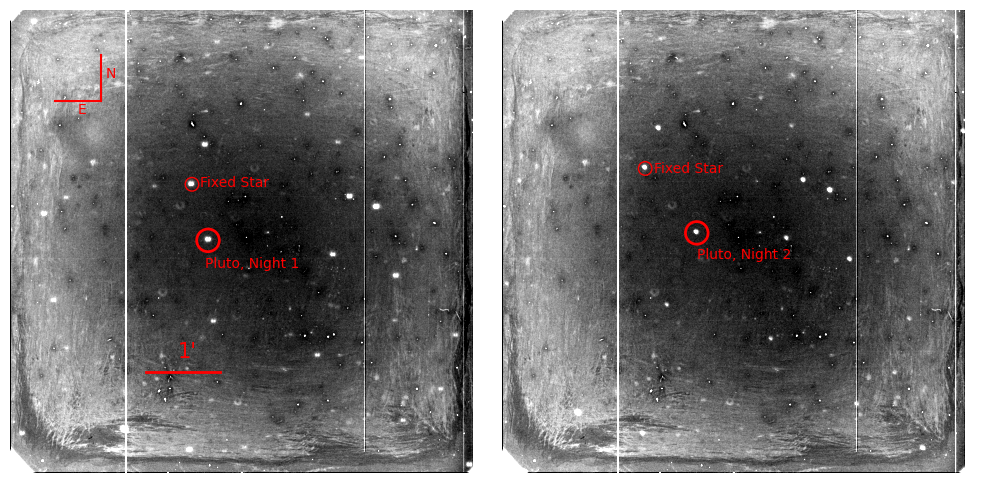

In [160]:
#res = (sci_frame - dark_image) / dome_flat_frame
res1 = sci_n1 # sci_frame_n1
res2 = sci_n2
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(res1, cmap='grey', vmin=np.percentile(res1, 2), vmax=np.percentile(res1, 96))
# plt.colorbar()

y0n = 100
yn = np.linspace(y0n,y0n+100,1000 )
xn = [200]*len(yn)
ax[0].plot(xn,yn,c='red')

xe = np.linspace(100,200,1000)
ye = [200]*len(xe)
ax[0].plot(xe,ye,c='red')

ax[0].text(210,150,'N',c='red')
ax[0].text(150,230,'E',c='red')

x0s = 300
xs = np.linspace(x0s, x0s + x_w,1000)
ys = [800]*len(xs)
ax[0].plot(xs,ys,c='red',linewidth=2)
ax[0].text(370,770,"1'",c='red',size=15)

# Fixed Star
circle1_f1 = plt.Circle((402, 385), 15, color='r', linewidth=1,fill=False)
circle2_f1 = plt.Circle((315, 350), 15, color='r', linewidth=1,fill=False)

# Pluto
circle1 = plt.Circle((437.413, 509.01), 25, color='r', linewidth=2,fill=False)
circle2 = plt.Circle((429.121, 492.532), 25, color='r', linewidth=2,fill=False)

ax[1].imshow(res2, cmap='grey', vmin=np.percentile(res2, 2), vmax=np.percentile(res2, 96))

ax[0].text(430,570, "Pluto, Night 1", c='red')
ax[1].text(430,550, "Pluto, Night 2", c='red')

ax[0].text(420,390,'Fixed Star',c='red')
ax[1].text(335,360,'Fixed Star',c='red')

ax[0].add_patch(circle1)
ax[0].add_patch(circle1_f1)

ax[1].add_patch(circle2)
ax[1].add_patch(circle2_f1)
# ax[0].add_patch(circle_f2)

# plt.colorbar()
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()

plt.savefig("pluto_imgs.pdf",bbox_inches="tight")

#### 2. Determine distance to Pluto

In [174]:
# First, we measure the angular distance Pluto moves from night 1 to night 2. 

anchor_n1 = np.array([400.486, 386.277])
pluto_n1 = np.array([437.413, 509.01])
rel_n1 =  pluto_n1 - anchor_n1
print(rel_n1)
anchor_n2 = np.array([314.654, 350.065])
pluto_n2 = np.array([429.121, 492.532])
rel_n2 = pluto_n2 - anchor_n2
print(rel_n2)
pix_diff = np.linalg.norm(2*(rel_n2-rel_n1)) # Distance pluto moved (pixels)
print("Distance Pluto moves", pix_diff, 'pixels')
plate_scale = 0.184 # arcsec/pixel plate scale of Nickel Telescope

theta = pix_diff * plate_scale 
print("Angular Distance Pluto Moves", theta, 'arcsec')

# convert to degrees
theta *= (1/3600)
print("Angular Distance Pluto Moves", theta, 'deg')

[ 36.927 122.733]
[114.467 142.467]
Distance Pluto moves 160.02352772014487 pixels
Angular Distance Pluto Moves 29.444329100506657 arcsec
Angular Distance Pluto Moves 0.008178980305696294 deg


In [162]:
# Next we compute the distance Earth Moves between nights 1 and 2 assuming Pluto doesn't move 

time_diff = 24 * (60 * 60)
v_Earth = 30 # km/se
d_E = (1/365)*(2*np.pi*1) #time_diff * v_Earth
d_E 

0.01721420632103996

In [163]:
d_p_km = (d_E) / (np.tan(np.deg2rad(theta)))
d_p_km

120.58977113279188

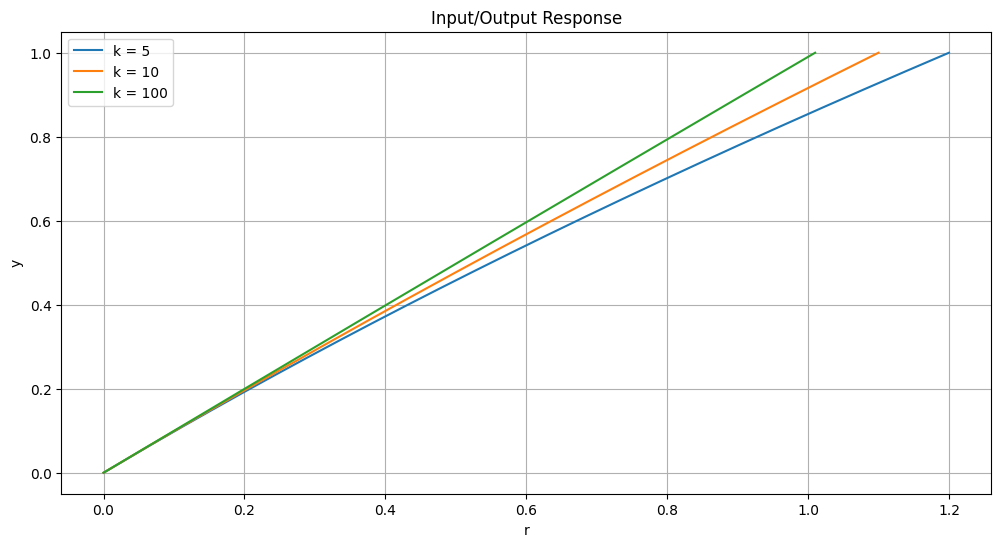

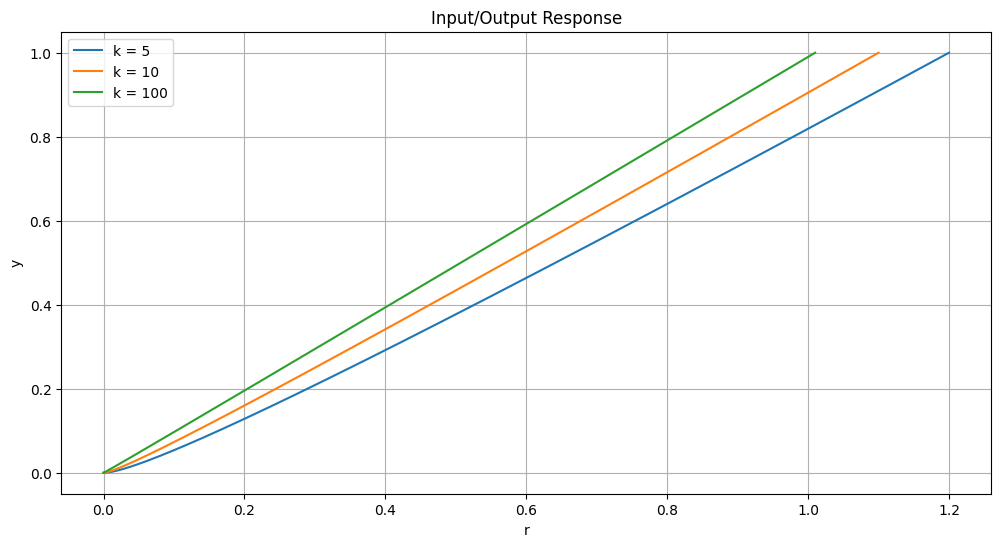

In [173]:
import numpy as np
import matplotlib.pyplot as plt

def plot_response(f, f_inv, k_values, u_range):
    u = np.linspace(u_range[0], u_range[1], 500)
    plt.figure(figsize=(12, 6))
    
    for k in k_values:
        y = f(u)
        r = y + (1/k) * f_inv(y)
        plt.plot(r, y, label=f'k = {k}')
    
    plt.xlabel('r')
    plt.ylabel('y')
    plt.title('Input/Output Response')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the functions
f_sqrt = lambda u: np.sqrt(u)
f_inv_sqrt = lambda y: y**2

f_square = lambda u: u**2
f_inv_square = lambda y: np.sqrt(y)

# Plot for f(u) = sqrt(u)
plot_response(f_sqrt, f_inv_sqrt, [5, 10, 100], [0, 1])

# Plot for f(u) = u^2
plot_response(f_square, f_inv_square, [5, 10, 100], [0, 1])